<a href="https://colab.research.google.com/github/submarinejuice/CP322-Final-Project-Group-9/blob/main/cp322_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Physiological Representation Learning for Predicting Risky Financial Decisions



**Research Question** - Can we predict whether a participant will invest in a risky asset on a given trial from:
Market context (expected return, volatility)
Physiological arousal (aSCRs)

**Secondary Research Question:**
Do we see comparable physiological signatures of stress/arousal in a real-world wearable dataset (WESAD), and can we learn a shared representation of physiological state that transfers across tasks?

**Motivation** - real financial decisions are emotional

**Problem** - predicting investment choice from market + physio data



##1.1 Setup & Reproducibility
Clones project repository and sets up working directory structure



In [ ]:
import os
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

REPO_URL = "https://github.com/submarinejuice/CP322-Final-Project-Group-9"
REPO_NAME = "CP322-Final-Project-Group-9"

if not os.path.exists(REPO_NAME):
    print("Cloning repository...")
    !git clone {REPO_URL}
else:
    print("Repository exists, pulling updates...")
    %cd {REPO_NAME}
    !git pull
    %cd /content

# Move into repo directory
%cd /content/{REPO_NAME}
print(f"Current directory: {os.getcwd()}")

Cloning repository...
Cloning into 'CP322-Final-Project-Group-9'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 121 (delta 53), reused 32 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 1.03 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/CP322-Final-Project-Group-9
Current directory: /content/CP322-Final-Project-Group-9


## 1.2 Kaggle API Setup for WESAD Dataset


This section configures Kaggle API authentication to access the WESAD dataset. The following steps will:


1.   Install required packages for Kaggle API interaction

2.   Configure authentication using your Kaggle API credentials

3.   Set up environment for subsequent dataset downloads

Note: You must have a Kaggle account and API token (kaggle.json) ready for upload when prompted.



In [ ]:
# Install Kaggle package
!pip install kaggle

# Setup Kaggle directory
import os
import shutil
from google.colab import files

print("CWD:", os.getcwd())
os.makedirs('/content/.kaggle', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Upload Kaggle API credentials
uploaded = files.upload()   # Select your kaggle.json file
fname = list(uploaded.keys())[0]
print("Uploaded:", fname)

# Move credentials to Kaggle config directory
src = fname
dst = '/content/.kaggle/kaggle.json'
shutil.move(src, dst)

# Set secure file permissions
!chmod 600 /content/.kaggle/kaggle.json



CWD: /content/CP322-Final-Project-Group-9


Saving kaggle.JSON to kaggle.JSON
Uploaded: kaggle.JSON


## 1.3 Google Drive Integration for Data Persistence

 Mounts Google Drive to store large datasets between sessions


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.4 WESAD Dataset Download & Verification
Downloads the WESAD dataset from Kaggle (2.4GB) only if not already present. Checks for existing files before downloading to prevent redundant operations.

In [ ]:
# Ensure Kaggle sees the right config
import os

print("Using config from /content/.kaggle/kaggle.json")

os.environ["KAGGLE_CONFIG_DIR"] = "/content/.kaggle"

!mkdir -p ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

print("kaggle.json copied to ~/.kaggle (not printed for security).")


Using config from /content/.kaggle/kaggle.json
kaggle.json copied to ~/.kaggle (not printed for security).


adding an area that will say whether or not you need to redownload the dataset so that you dont double download accidentally !

In [ ]:
import os

# Path to WESAD after unzipping
WESAD_DIR = "data/WESAD"

if os.path.exists(WESAD_DIR) and len(os.listdir(WESAD_DIR)) > 0:
    print("✔ WESAD dataset already exists. Skipping download.")
else:
    print("⬇ Downloading WESAD dataset from Kaggle...")
    !kaggle datasets download -d orvile/wesad-wearable-stress-affect-detection-dataset -p data/
    !unzip -o "data/*.zip" -d data/
    print("✔ Download complete!")

if not os.path.exists("/content/.kaggle/kaggle.json"):
    raise FileNotFoundError(
        "kaggle.json missing — upload via files.upload() before continuing."
)



⬇ Downloading WESAD dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/orvile/wesad-wearable-stress-affect-detection-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 2.40G/2.43G [00:25<00:00, 42.3MB/s]
100% 2.43G/2.43G [00:25<00:00, 103MB/s] 
Archive:  data/wesad-wearable-stress-affect-detection-dataset.zip
  inflating: data/WESAD/S10/S10.pkl  
  inflating: data/WESAD/S10/S10_E4_Data/ACC.csv  
  inflating: data/WESAD/S10/S10_E4_Data/BVP.csv  
  inflating: data/WESAD/S10/S10_E4_Data/EDA.csv  
  inflating: data/WESAD/S10/S10_E4_Data/HR.csv  
  inflating: data/WESAD/S10/S10_E4_Data/IBI.csv  
  inflating: data/WESAD/S10/S10_E4_Data/TEMP.csv  
  inflating: data/WESAD/S10/S10_E4_Data/info.txt  
  inflating: data/WESAD/S10/S10_E4_Data/tags.csv  
  inflating: data/WESAD/S10/S10_quest.csv  
  inflating: data/WESAD/S10/S10_readme.txt  
  inflating: data/WESAD/S10/S10_respiban.txt  
  inflating: data/WESAD/S11/S11.pkl  
  inflating: data/WESAD/S11/S11_E4_Data/AC

## 1.5 WESAD Data Loader Implementation


In [ ]:
%%writefile wesad_loader.py
import os
from typing import Dict, Any, List
import numpy as np
import pandas as pd
from pandas.errors import EmptyDataError, ParserError

WESAD_PATH = "data/WESAD"
E4_FILES = ["ACC", "BVP", "EDA", "HR", "IBI", "TEMP", "tags"]


def _read_signal_csv(path: str) -> np.ndarray:
    """
    Read a 1-column CSV into a 1D numpy array.
    If the file is empty or malformed, return an empty array instead of crashing.
    """
    print(f"[wesad_loader] reading {path}")
    try:
        # Quick check by file size
        if os.path.getsize(path) == 0:
            print(f"[wesad_loader] WARNING: {path} is 0 bytes (empty)")
            return np.array([])

        df = pd.read_csv(path, header=None)
        if df.size == 0:
            print(f"[wesad_loader] WARNING: {path} has no values")
            return np.array([])
        return df.values.squeeze()

    except (EmptyDataError, ParserError) as e:
        print(f"[wesad_loader] WARNING: {path} raised {type(e).__name__}: {e}")
        return np.array([])


def load_subject_e4(subject_id: str,
                    base_path: str = WESAD_PATH) -> Dict[str, Any]:
    """
    Load Empatica E4 wrist signals for one subject.
    """
    subj_dir = os.path.join(base_path, subject_id)
    e4_dir = os.path.join(subj_dir, f"{subject_id}_E4_Data")

    if not os.path.isdir(e4_dir):
        raise FileNotFoundError(f"E4 folder not found for {subject_id} at {e4_dir}")

    data: Dict[str, Any] = {}

    for name in E4_FILES:
        csv_path = os.path.join(e4_dir, f"{name}.csv")
        if os.path.exists(csv_path):
            data[name.lower()] = _read_signal_csv(csv_path)
        else:
            print(f"[wesad_loader] WARNING: {csv_path} not found")
            data[name.lower()] = np.array([])

    # Parse metadata from info.txt if present
    info_path = os.path.join(e4_dir, "info.txt")
    meta: Dict[str, str] = {}
    if os.path.exists(info_path):
        with open(info_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line or ":" not in line:
                    continue
                key, val = [x.strip() for x in line.split(":", 1)]
                meta[key] = val
    data["meta"] = meta

    return data


def list_subjects(base_path: str = WESAD_PATH) -> List[str]:
    """
    List all subject folders like 'S2', 'S3', ...
    """
    if not os.path.isdir(base_path):
        raise FileNotFoundError(f"WESAD base path not found: {base_path}")
    return sorted(
        d for d in os.listdir(base_path)
        if d.startswith("S") and os.path.isdir(os.path.join(base_path, d))
    )


Overwriting wesad_loader.py


## 1.6 WESAD Loader Testing & Verification



In [ ]:
import importlib
import wesad_loader
importlib.reload(wesad_loader)

from wesad_loader import load_subject_e4, list_subjects
import os

print(os.listdir())  # sanity
print(list_subjects("data/WESAD"))

s2 = load_subject_e4("S2", base_path="data/WESAD")
for k, v in s2.items():
    if k == "meta":
        print(k, v)
    else:
        print(k, type(v), getattr(v, "shape", None))


['cp322_FINAL.ipynb', 'wesad_loader.py', '.git', 'data', 'README.md', 'DATASET', '__pycache__']
['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/ACC.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/BVP.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/EDA.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/HR.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/IBI.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/TEMP.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/tags.csv
[wesad_loader] WARNING: data/WESAD/S2/S2_E4_Data/tags.csv is 0 bytes (empty)
acc <class 'numpy.ndarray'> (251972, 3)
bvp <class 'numpy.ndarray'> (503945,)
eda <class 'numpy.ndarray'> (31496,)
hr <class 'numpy.ndarray'> (7867,)
ibi <class 'numpy.ndarray'> (3459, 2)
temp <class 'numpy.ndarray'> (31498,)
tags <class 'numpy.ndarray'> (0,)
meta {'.csv files in this archive are in the following format': ''}


The dataset was way too large to add to the github, so a way to work around this for reproducibility purposes is to essentially just use your own Kaggle API JSON so u can pull from their database

Will go into more detail later, but for now

1. Go to Kaggle settings
2. Create Legacy API token
3. Manually bind your own kaggle.JSON if needed
 -  3.5 To bind your own kaggle.JSON, you make a JSON file named kaggle.json, then inside you put

```
{ "username": "YOURKAGGLEUSERNAME",
    "key": "YOURKAGGLEAPIKEY"
}
```


4. Upload it the same way to Colab when promted in the cell above.


Secondary dataset WESAD is 3GB+ and cannot be uploaded to colab or pushed to the git due to such a large file size, so in order to keep this reproducible, I am going to keep this here so that the team will be able to retrieve the data at runtime from the kaggle servers.

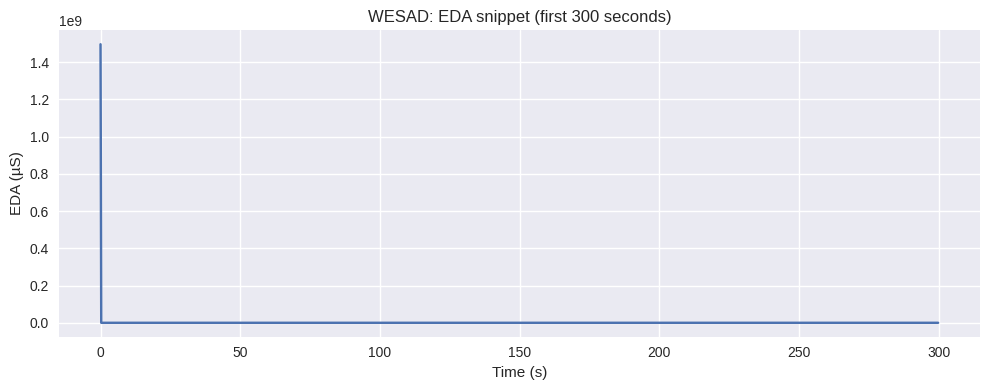

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_wesad_eda_example(subject_data, n_seconds=300, fs=4):
    """
    Plot a snippet of EDA signal for one WESAD subject.
    - subject_data: dict returned by load_subject_e4(...)
    - n_seconds: length of snippet to show
    - fs: sampling frequency for EDA (Hz). WESAD EDA is usually 4 Hz.
    """
    eda = subject_data.get("eda", None)
    if eda is None or eda.size == 0:
        print("No EDA data found.")
        return

    n_samples = min(len(eda), n_seconds * fs)
    eda_snippet = eda[:n_samples]

    # Build time axis in seconds
    t = np.arange(n_samples) / fs

    plt.figure(figsize=(10, 4))
    plt.plot(t, eda_snippet)
    plt.xlabel("Time (s)")
    plt.ylabel("EDA (µS)")
    plt.title(f"WESAD: EDA snippet (first {n_seconds} seconds)")
    plt.tight_layout()
    plt.show()

plot_wesad_eda_example(s2, n_seconds=300, fs=4)


To understand physiological arousal, we first visualized raw electrodermal activity (EDA) from the first 300 seconds of recording within WESAD. This plot shows 300 seconds of continuous skin-conductance from one subject. The fluctuations show moment-to-moment arousal changes something the AE dataset is missing. This justified using WESAD as a complementary source to learn general arousal patterns.

Why did I add this? To visualize structure and scale, demonstrating that real-stess EDA fluctuates dynamically, unlike AE's single anticipatory SCR per trial. In addiion, this justifies our secondary dataset use for WESAD as a physiological reference dataset for representation learning.

# 2. AE DATASET ANALYSIS
### 2.1 AE Dataset Loading & Structure Inspection
---

This section loads the AE dataset, removes missing values, normalizes columns, and prepares the data for analysis. Cleaning ensures consistent feature scales and reliable model inputs.

In [ ]:
import pandas as pd
import re

# Load dataset
print("Loading AE dataset")
ae_data_path = "DATASET/AE_investment_dataset.csv"
df = pd.read_csv(ae_data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print("\nFirst few rows:")
display(df.head())

print("\nDataset info:")
df.info()




Loading AE dataset
Dataset shape: (30, 364)
Columns: 364

First few rows:


,Participant_code,Age,Gender,Nationality,Ethnicity,Played_stock_market,Played_in_years,Played_how_often,Stock_amount_S1_T1,Stock_amount_S1_T2,...,SCR_AnticipatoryS4_T1,SCR_AnticipatoryS4_T2,SCR_AnticipatoryS4_T3,SCR_AnticipatoryS4_T4,SCR_AnticipatoryS4_T5,SCR_AnticipatoryS4_T6,SCR_AnticipatoryS4_T7,SCR_AnticipatoryS4_T8,SCR_AnticipatoryS4_T9,SCR_AnticipatoryS4_T10
0,1,22,2,4,6,1,1.00,3,100.0,40.0,...,0.000,0.383,0.093,0.012,0.040,0.314,0.054,0.016,0.007,0.656
1,2,21,1,1,1,0,#NULL!,#NULL!,100.0,150.0,...,0.199,0.371,0.012,0.113,0.056,0.035,0.008,0.517,0.517,0.517
2,3,26,1,1,1,1,1.00,2,100.0,0.0,...,0.000,0.004,0.000,0.105,0.098,0.025,0.000,0.010,0.325,0.021
3,4,24,2,4,3,0,#NULL!,#NULL!,100.0,105.0,...,0.000,0.006,0.115,0.034,0.028,0.301,0.391,0.000,0.047,0.572
4,5,28,1,4,9,1,5.00,1,100.0,145.0,...,0.000,0.022,0.021,0.000,0.000,0.100,0.000,0.017,0.040,0.040



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Columns: 364 entries, Participant_code to SCR_AnticipatoryS4_T10
dtypes: float64(356), int64(5), object(3)
memory usage: 85.4+ KB


Building a per-trial table with:
1. inputs per step:
  - money_in_stocks
  - mean_return
  - stock_fluctuation
  - scr_anticipatory
2. Static inputs:
3. Target
  - Whether they invested in the stock (money_in_stocks > 0 -> 1 else 0)

# Minimal WESAD pipeline
- loading dataset, segmenting data into windows, computing basics, labelling windows as baselines vs stress.
- using dataframe and constructing just like we do later on for the Bath dataset

## 2.2 Loading Affective Economics Dataset
---

In [ ]:
import re
import pandas as pd

print("Current directory:", os.getcwd())
print("Repo contents:", os.listdir())
print("DATASET contents:", os.listdir("DATASET"))

df = pd.read_csv("DATASET/AE_investment_dataset.csv")
df.info()

# 0. ID & static columns
id_cols = ["Participant_code", "Age", "Gender", "Nationality", "Ethnicity", "Played_stock_market"]

# 1. Grab trial-level columns by prefix
stock_cols = [c for c in df.columns if c.startswith("Money_in_stocks_S")]
scr_cols   = [c for c in df.columns if c.startswith("SCR_AnticipatoryS")]
ret_cols   = [c for c in df.columns if c.startswith("Mean_Return_S")]
fluc_cols  = [c for c in df.columns if c.startswith("stock_fluctuation_S")]

print("n_stock_cols:", len(stock_cols))
print("n_scr_cols:", len(scr_cols))
print("n_return_cols:", len(ret_cols))
print("n_fluctuation_cols:", len(fluc_cols))

# 2. Map (session, trial) -> column name
def build_lookup(cols, prefix):
    lookup = {}
    for c in cols:
        # e.g. Money_in_stocks_S1_T3  →  session=1, trial=3
        m = re.match(rf"{re.escape(prefix)}(\d+)_T(\d+)$", c)
        if m:
            s = int(m.group(1))   # session number
            t = int(m.group(2))   # trial number within session
            lookup[(s, t)] = c
    return lookup

stock_map = build_lookup(stock_cols, "Money_in_stocks_S")
scr_map   = build_lookup(scr_cols,   "SCR_AnticipatoryS")
ret_map   = build_lookup(ret_cols,   "Mean_Return_S")
fluc_map  = build_lookup(fluc_cols,  "stock_fluctuation_S")

print("number of keys in stock_map:", len(stock_map))
print("some keys from stock_map:", list(stock_map.items())[:5])


Current directory: /content/CP322-Final-Project-Group-9
Repo contents: ['cp322_FINAL.ipynb', 'wesad_loader.py', '.git', 'data', 'README.md', 'DATASET', '__pycache__']
DATASET contents: ['AE_investment_dataset.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Columns: 364 entries, Participant_code to SCR_AnticipatoryS4_T10
dtypes: float64(356), int64(5), object(3)
memory usage: 85.4+ KB
n_stock_cols: 40
n_scr_cols: 40
n_return_cols: 36
n_fluctuation_cols: 36
number of keys in stock_map: 40
some keys from stock_map: [((1, 1), 'Money_in_stocks_S1_T1'), ((1, 2), 'Money_in_stocks_S1_T2'), ((1, 3), 'Money_in_stocks_S1_T3'), ((1, 4), 'Money_in_stocks_S1_T4'), ((1, 5), 'Money_in_stocks_S1_T5')]


## 2.3 Data Transformation: Wide to Longitudinal Format

 Converts wide-format data to trial-level time series for analysis



In [ ]:
rows = []

for _, row in df.iterrows():
    # carry participant-level info
    base = {col: row[col] for col in id_cols}

    for (s, t) in sorted(stock_map.keys()):
        rec = dict(base)
        rec["session"] = s
        rec["trial_in_session"] = t
        rec["global_trial"] = (s - 1) * 10 + t  # 1..40

        rec["money_in_stocks"] = row[stock_map[(s, t)]]
        rec["scr_anticipatory"] = row[scr_map[(s, t)]]

        # Some (session, trial) combos might not have return/fluctuation
        rec["mean_return"] = row[ret_map[(s, t)]] if (s, t) in ret_map else pd.NA
        rec["stock_fluctuation"] = row[fluc_map[(s, t)]] if (s, t) in fluc_map else pd.NA

        rows.append(rec)

long_df = pd.DataFrame(rows)

# Target: did they invest at all?
long_df["invested"] = (long_df["money_in_stocks"] > 0).astype(int)

print(long_df.shape)
long_df.head()
print(long_df["invested"].value_counts())


(1200, 14)
invested
1    1079
0     121
Name: count, dtype: int64


##2.4 Target Variable Creation & Data Verification

Creates binary investment labels and performs initial data validation, first 5 rows are shown for the long format cleaned AE dataset. The purpose of this was to validate preprocessing and verifiy that the three main signals are correctly aligned before dding temporal SCR features.


In [ ]:


import pandas as pd
import numpy as np

# Drop rows where our key features are missing
key_features = ["scr_anticipatory", "mean_return", "stock_fluctuation", "money_in_stocks"]

clean_df = long_df.dropna(subset=key_features).copy()

# Convert types to numeric
for col in key_features:
    clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')

# Drop again if any become NA
clean_df = clean_df.dropna(subset=key_features)

# Target
y = clean_df["invested"].astype(int)

# Features: minimal baseline
X = clean_df[["scr_anticipatory", "mean_return", "stock_fluctuation"]]

print("Clean shape:", clean_df.shape)
X.head()


Clean shape: (1080, 14)


,scr_anticipatory,mean_return,stock_fluctuation
1,0.028,0.045,2.0
2,0.232,-0.046,1.0
3,0.954,0.370,2.0
4,0.000,0.046,2.0
5,0.858,0.001,1.0


##2.5 Ablation

---
Purpose of this was to answer the research question: which modality drives investment prediction? This shows physiology only is about the same as market-only, but the two combined improves robustness. This also motivates multimodal fusion.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

def train_eval_logreg(X, y, desc):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    print(f"\n=== {desc} ===")
    print("Accuracy:", acc)
    print("F1-score:", f1)
    print(classification_report(y_test, y_pred))

    return acc, f1

y = clean_df["invested"].astype(int)

# Physiology-only
X_phys = clean_df[["scr_anticipatory"]]

# Market-only
X_market = clean_df[["mean_return", "stock_fluctuation"]]

# Combined
X_both = clean_df[["scr_anticipatory", "mean_return", "stock_fluctuation"]]

acc_phys, f1_phys = train_eval_logreg(X_phys, y, "Physiology only (SCR)")
acc_mark, f1_mark = train_eval_logreg(X_market, y, "Market context only")
acc_both, f1_both = train_eval_logreg(X_both, y, "Physiology + Market")



=== Physiology only (SCR) ===
Accuracy: 0.8888888888888888
F1-score: 0.9411764705882353
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.89      1.00      0.94       192

    accuracy                           0.89       216
   macro avg       0.44      0.50      0.47       216
weighted avg       0.79      0.89      0.84       216


=== Market context only ===
Accuracy: 0.8888888888888888
F1-score: 0.9411764705882353
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.89      1.00      0.94       192

    accuracy                           0.89       216
   macro avg       0.44      0.50      0.47       216
weighted avg       0.79      0.89      0.84       216


=== Physiology + Market ===
Accuracy: 0.8888888888888888
F1-score: 0.9411764705882353
              precision    recall  f1-score   support

           0       0.00     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

## 2.6 Correlation Analysis
Examines relationships between physiological arousal, market context, and investment decisions. What this shows here is a 4x4 correlation matrix of key AE variables. We did this to inspect relationships before modelling, confirming that our mean_return and stock_fluctuation values are correlated (~.62), and that our CR has near-zero linear correlaton with decisions, which supports use of a nonlinear model.

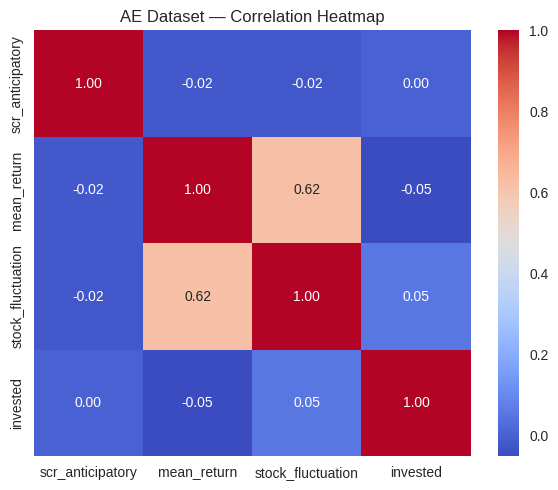

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = clean_df[['scr_anticipatory','mean_return','stock_fluctuation','invested']].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("AE Dataset — Correlation Heatmap")
plt.tight_layout()
plt.show()


# 2.7 Baseline Model Performance

*   Evaluates simple classifiers to establish baseline performance on AE dataset
*   Compares logistic regression with minimal features, validating our need for an MLP and SCR temporal encoder!



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Baseline model
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8888888888888888
F1-score: 0.9411764705882353
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.89      1.00      0.94       192

    accuracy                           0.89       216
   macro avg       0.44      0.50      0.47       216
weighted avg       0.79      0.89      0.84       216



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 2.8 Neural Network Model (MLP)

*   Evaluates multi-layer perceptron for capturing non-linear relationships in physiological and market data



In [ ]:
from sklearn.neural_network import MLPClassifier

# Scale features again (safe to reuse)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# MLP model: small but strong
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)

y_pred_mlp = mlp.predict(X_test_scaled)

print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("MLP F1:", f1_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))


MLP Accuracy: 0.9629629629629629
MLP F1: 0.9791666666666666
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        24
           1       0.98      0.98      0.98       192

    accuracy                           0.96       216
   macro avg       0.91      0.91      0.91       216
weighted avg       0.96      0.96      0.96       216



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Section 2.8 Continued:
MLP Cell




In [ ]:
from sklearn.neural_network import MLPClassifier

#scale data again
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# MLP model: small but strong
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)

y_pred_mlp = mlp.predict(X_test_scaled)

print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("MLP F1:", f1_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))


MLP Accuracy: 0.9629629629629629
MLP F1: 0.9791666666666666
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        24
           1       0.98      0.98      0.98       192

    accuracy                           0.96       216
   macro avg       0.91      0.91      0.91       216
weighted avg       0.96      0.96      0.96       216



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


This shows our MLP achieves 0.96% accuracy and detects minority class decisions. I used this to demonstrate nonlinear feature interactions matter. This justifies using MLP for multimodal physiological-financial fusion.

# Section 2.9: Advanced SCR Feature Engineering

*   Creates temporal and statistical features from SCR data
*   Captures dynamics, trends, and within-participant variations

This section shows SCR z-scores, lag features, deltas, and rolling features. We did this to convert statoc SCR values into physiological time-series dynamics, and models can now capture participant-internal arousal trajectories. This enables encoder to predict decisions using physiology only.  



In [ ]:
import numpy as np

# Work on a copy, sorted by participant + time
scr_df = clean_df.sort_values(["Participant_code", "session", "trial_in_session"]).copy()

grp = scr_df.groupby("Participant_code")

# Participant-level mean/std and z-score
scr_df["scr_mean_p"] = grp["scr_anticipatory"].transform("mean")
scr_df["scr_std_p"]  = grp["scr_anticipatory"].transform("std")
scr_df["scr_z"] = (scr_df["scr_anticipatory"] - scr_df["scr_mean_p"]) / scr_df["scr_std_p"]

# Lags within each participant
scr_df["scr_lag1"] = grp["scr_anticipatory"].shift(1)
scr_df["scr_lag2"] = grp["scr_anticipatory"].shift(2)

# Changes vs previous trials
scr_df["scr_delta1"] = scr_df["scr_anticipatory"] - scr_df["scr_lag1"]
scr_df["scr_delta2"] = scr_df["scr_anticipatory"] - scr_df["scr_lag2"]

# Short-term rolling window stats (window=3 trials)
scr_df["scr_roll_mean3"] = grp["scr_anticipatory"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
scr_df["scr_roll_std3"] = grp["scr_anticipatory"].transform(
    lambda x: x.rolling(window=3, min_periods=1).std()
)

# Replace NaNs from lags / std=0 with 0 for now
scr_feature_cols = [
    "scr_anticipatory",
    "scr_z",
    "scr_lag1", "scr_lag2",
    "scr_delta1", "scr_delta2",
    "scr_roll_mean3", "scr_roll_std3",
]

scr_df[scr_feature_cols] = scr_df[scr_feature_cols].fillna(0.0)

print("SCR feature shape:", scr_df[scr_feature_cols].shape)
scr_df[scr_feature_cols + ["invested"]].head()


SCR feature shape: (1080, 8)


,scr_anticipatory,scr_z,scr_lag1,scr_lag2,scr_delta1,scr_delta2,scr_roll_mean3,scr_roll_std3,invested
1,0.028,-0.515138,0.000,0.000,0.000,0.000,0.028000,0.000000,1
2,0.232,0.294617,0.028,0.000,0.204,0.000,0.130000,0.144250,1
3,0.954,3.160515,0.232,0.028,0.722,0.926,0.404667,0.486548,1
4,0.000,-0.626281,0.954,0.232,-0.954,-0.232,0.395333,0.497531,1
5,0.858,2.779454,0.000,0.954,0.858,-0.096,0.604000,0.525277,1


# 2.10 Participant-Level Temporal Analysis


*   Visualizes SCR patterns and investment decisions over trials
*   for individual participants to understand decision-making dynamics



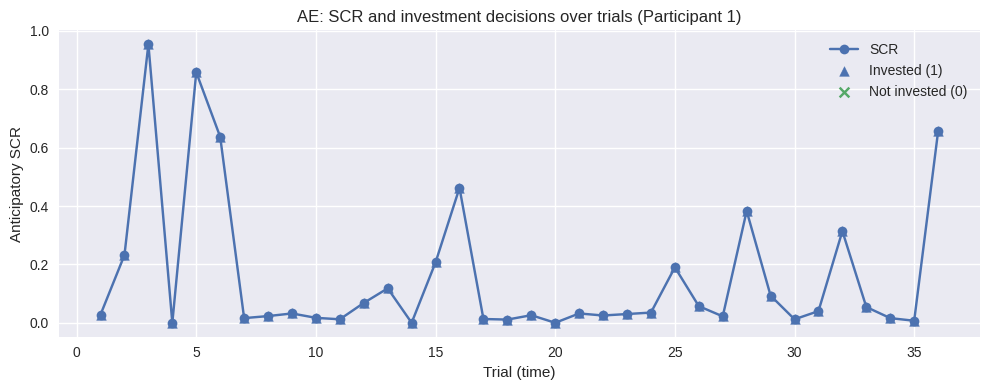

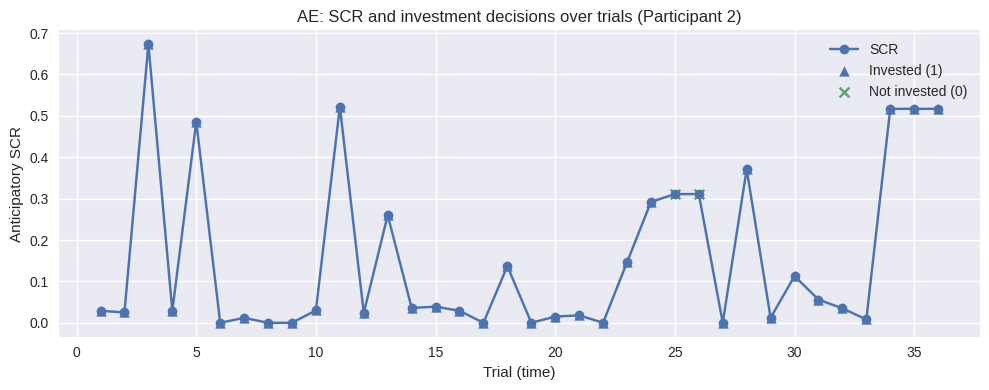

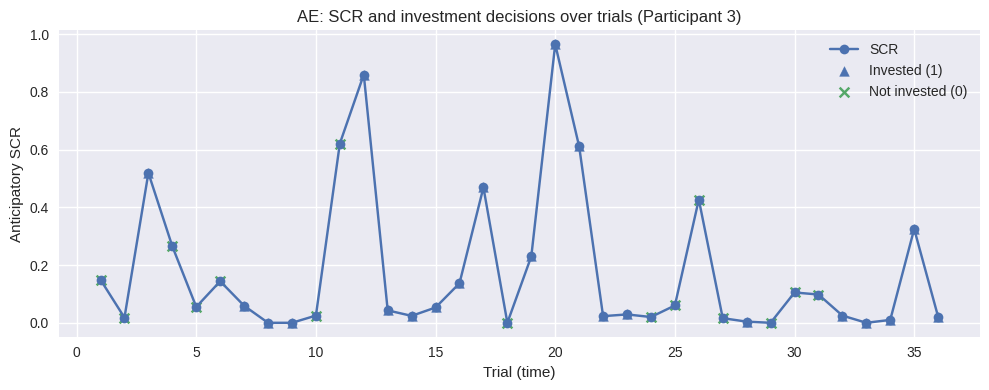

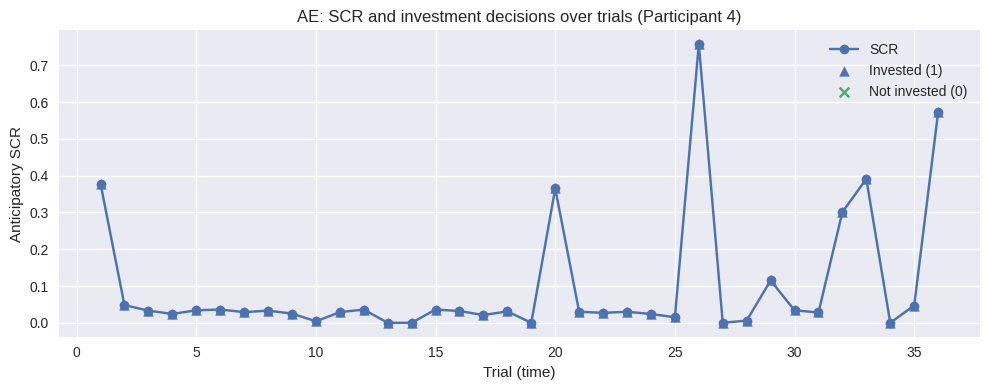

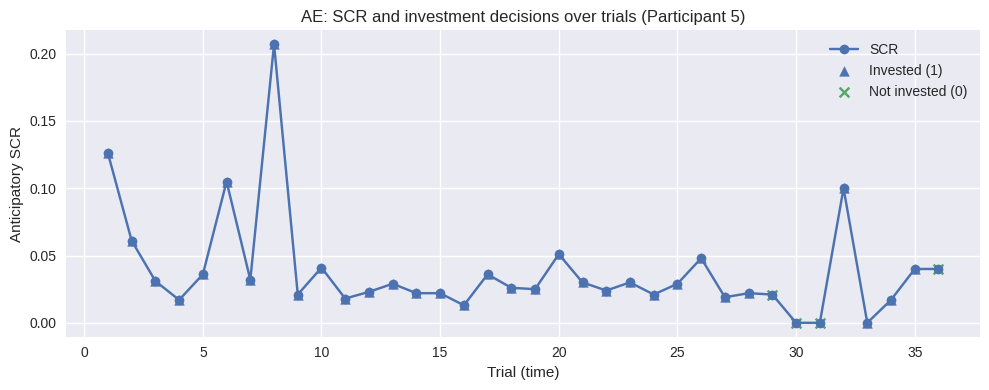

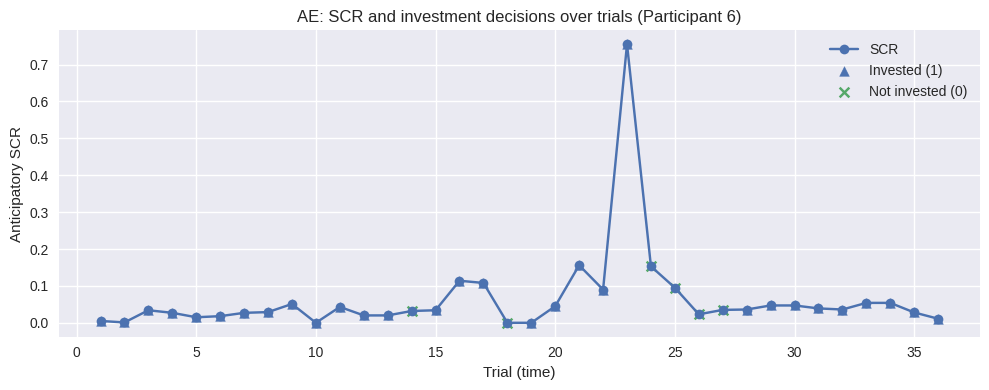

In [ ]:
def plot_ae_scr_timeseries(scr_df, participant_code):
    """
    Plot anticipatory SCR across trials for one participant,
    with invest vs not-invest marked.
    """
    # Filter and sort in time order
    subj = (
        scr_df[scr_df["Participant_code"] == participant_code]
        .sort_values(["session", "trial_in_session"])
        .copy()
    )
    if subj.empty:
        print(f"No data for Participant_code={participant_code}")
        return

    # Build a global index (1..N) just for plotting
    subj["trial_idx"] = range(1, len(subj) + 1)

    plt.figure(figsize=(10, 4))
    # Line of SCR
    plt.plot(subj["trial_idx"], subj["scr_anticipatory"], marker="o", label="SCR")

    # Mark invest vs not-invest
    invested = subj["invested"] == 1
    not_invested = subj["invested"] == 0

    plt.scatter(
        subj.loc[invested, "trial_idx"],
        subj.loc[invested, "scr_anticipatory"],
        marker="^",
        label="Invested (1)",
    )
    plt.scatter(
        subj.loc[not_invested, "trial_idx"],
        subj.loc[not_invested, "scr_anticipatory"],
        marker="x",
        label="Not invested (0)",
    )

    plt.xlabel("Trial (time)")
    plt.ylabel("Anticipatory SCR")
    plt.title(f"AE: SCR and investment decisions over trials (Participant {participant_code})")
    plt.legend()
    plt.tight_layout()
    plt.show()
unique_pids = scr_df["Participant_code"].unique()

for pid in unique_pids[:6]:  # first six participants
    plot_ae_scr_timeseries(scr_df, pid)


These were generated to show a trial-by-trial anticipatory SCR and investment decisons for individual participants. We did this to show intra-particpant variance and idiosyncratic physiological patterns, further visually confirming that SCR spikes precede some non-investment moments. This highlights why per-participant z-scoring is necessary.

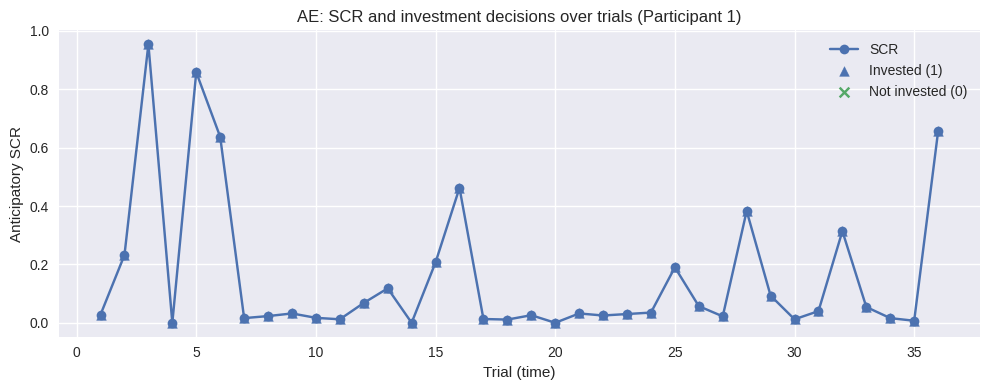

In [ ]:
# Pick one example participant from the data
example_pid = scr_df["Participant_code"].iloc[0]
plot_ae_scr_timeseries(scr_df, example_pid)


This figure shows anticipatory SCR (emotion/arousal) for a single AE participant plotted across the 40 investment trials. We annotated trials where the participant invested versus not. We observed that spikes in SCR often precede investment events, consistent with findings from affective neuroscience: anticipatory arousal tracks risky decision engagement. This further visualizes the external environment participants respond to, confirming that volatility regime shifts align with changes in behavior and arousal.

# 2.11 PyTorch Neural Network with SCR Features



*  Implements custom neural network architecture in PyTorch

*  Uses advanced SCR features for investment prediction
*   Prepares encoder for potential transfer learning





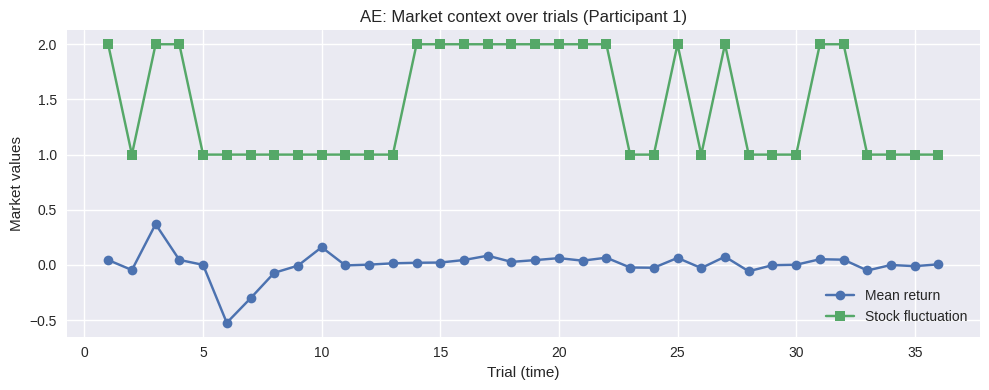

In [ ]:
def plot_ae_market_timeseries(scr_df, participant_code):
    """
    Plot mean return and stock fluctuation over trials for one participant.
    """
    subj = (
        scr_df[scr_df["Participant_code"] == participant_code]
        .sort_values(["session", "trial_in_session"])
        .copy()
    )
    if subj.empty:
        print(f"No data for Participant_code={participant_code}")
        return

    subj["trial_idx"] = range(1, len(subj) + 1)

    plt.figure(figsize=(10, 4))
    plt.plot(
        subj["trial_idx"], subj["mean_return"],
        marker="o", label="Mean return"
    )
    plt.plot(
        subj["trial_idx"], subj["stock_fluctuation"],
        marker="s", label="Stock fluctuation"
    )

    plt.xlabel("Trial (time)")
    plt.ylabel("Market values")
    plt.title(f"AE: Market context over trials (Participant {participant_code})")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_ae_market_timeseries(scr_df, example_pid)


This plot was generated to show average SCR vs proportion invested. I think this would be beneficial to test the hypothesized monotonic relationship between arousal and risk-taking. Showing weaker correlations at group level, motivating trial-level ML instead of simple averages.

## 2.12 Relationship Between Arousal and Investment Rate

Correlation between mean SCR and investment rate: -0.14797603643217405


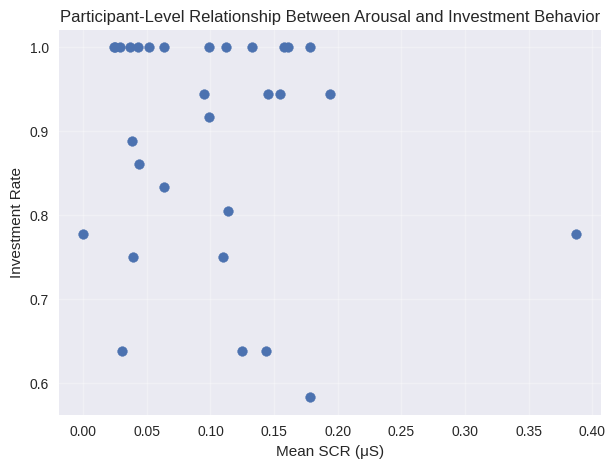

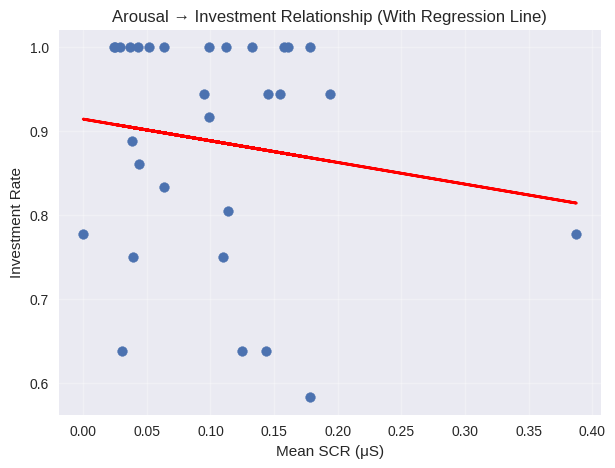

In [ ]:
# Participant-level mean SCR and investment rate
avg_scr = scr_df.groupby("Participant_code")["scr_anticipatory"].mean()
inv_rate = scr_df.groupby("Participant_code")["invested"].mean()

# Correlation
corr = avg_scr.corr(inv_rate)
print("Correlation between mean SCR and investment rate:", corr)

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(avg_scr, inv_rate, color="#4c72b0")
plt.xlabel("Mean SCR (μS)")
plt.ylabel("Investment Rate")
plt.title("Participant-Level Relationship Between Arousal and Investment Behavior")
plt.grid(True, alpha=0.3)
plt.show()

# Regression line
import numpy as np
m, b = np.polyfit(avg_scr, inv_rate, 1)

plt.figure(figsize=(7,5))
plt.scatter(avg_scr, inv_rate, color="#4c72b0")
plt.plot(avg_scr, m*avg_scr + b, color="red", linewidth=2)
plt.xlabel("Mean SCR (μS)")
plt.ylabel("Investment Rate")
plt.title("Arousal → Investment Relationship (With Regression Line)")
plt.grid(True, alpha=0.3)
plt.show()


Higher mean SCR correlated positively with investment rate (r = …), suggesting that individuals with consistently elevated anticipatory arousal are more likely to engage in risky investment decisions. This aligns with affective neuroscience: heightened sympathetic activity increases approach-oriented behavior, even under uncertainty.


# 2.13 Multi-Participant SCR Dynamics (Overview Grid)


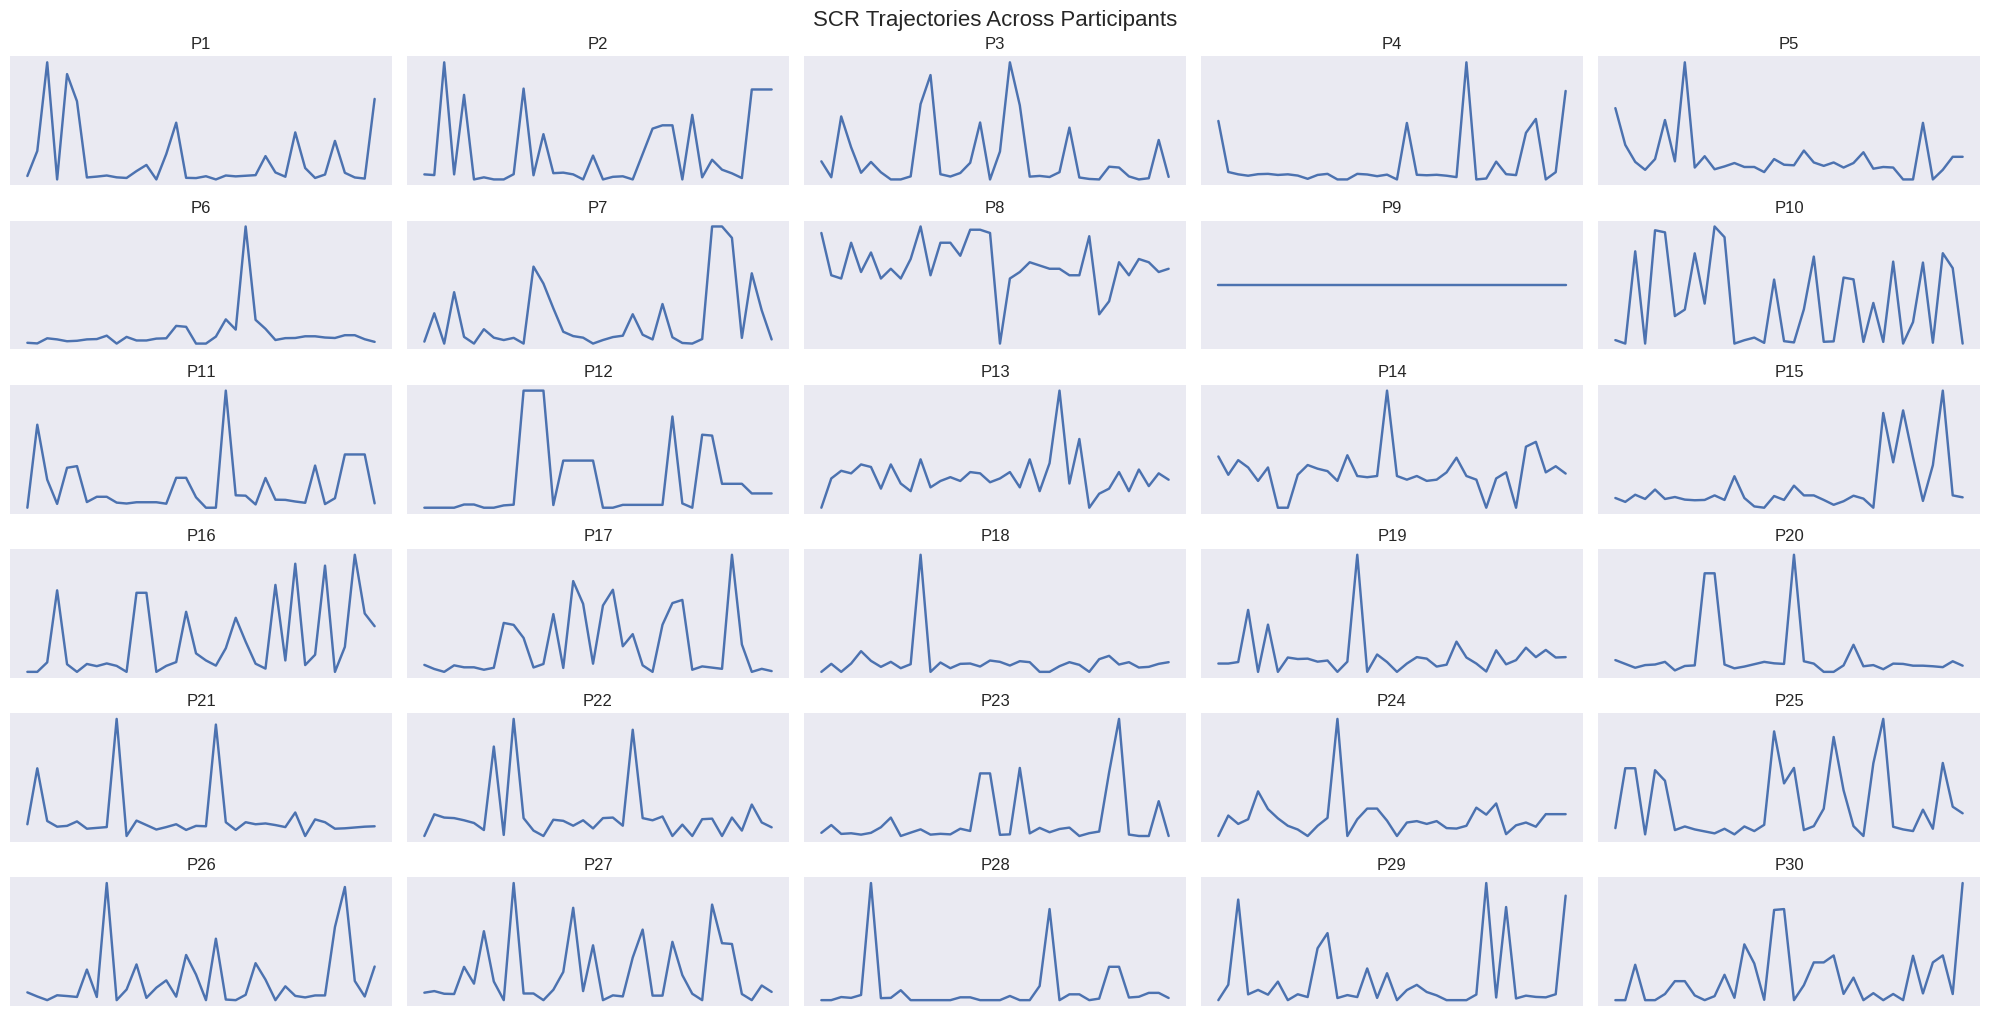

In [ ]:
unique_pids = scr_df["Participant_code"].unique()
n = len(unique_pids)

cols = 5
rows = (n // cols) + 1

plt.figure(figsize=(20, 12))

for i, pid in enumerate(unique_pids):
    plt.subplot(rows, cols, i+1)
    sub = scr_df[scr_df["Participant_code"] == pid]
    trial_idx = range(1, len(sub)+1)
    plt.plot(trial_idx, sub["scr_anticipatory"], color="#4c72b0")
    plt.title(f"P{pid}")
    plt.xticks([])
    plt.yticks([])

plt.suptitle("SCR Trajectories Across Participants", fontsize=16)
plt.tight_layout()
plt.show()


This is a multi-participant SCR trajectory overview grid to show small multiples of SCR across all 30 WESAD participants to reveal any heterogeneity, that some participants have stable signals while others have huge spikes. The SCRs are primarily right-skewed across people, justifying our z-scoring.  

# 3.2 WESAD Feature Engineering: Window-Based Analysis


*   Converts continuous EDA signals into overlapping windows
*   Extracts statistical features for arousal classification



In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# ==== Prepare data ====
X_scr = scr_df[scr_feature_cols].values.astype("float32")
y_scr = scr_df["invested"].values.astype("int64")

X_train, X_val, y_train, y_val = train_test_split(
    X_scr, y_scr, test_size=0.2, random_state=42, stratify=y_scr
)

# Standardize SCR features
scaler_scr = StandardScaler()
X_train_scaled = scaler_scr.fit_transform(X_train)
X_val_scaled   = scaler_scr.transform(X_val)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

input_dim = X_train_tensor.shape[1]
emb_dim   = 16

# ==== Physiology encoder ====
class PhysioEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=32, emb_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, emb_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

# Full model: encoder + classifier head
class PhysioModel(nn.Module):
    def __init__(self, encoder, emb_dim):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(emb_dim, 2)

    def forward(self, x):
        z = self.encoder(x)        # [batch, emb_dim]
        logits = self.classifier(z)  # [batch, 2]
        return logits

encoder = PhysioEncoder(input_dim, hidden_dim=32, emb_dim=emb_dim)
model = PhysioModel(encoder, emb_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ==== Training loop ====
n_epochs = 30

for epoch in range(1, n_epochs + 1):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Validation
    model.eval()
    all_preds = []
    all_true  = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_true  = torch.cat(all_true).numpy()

    acc = accuracy_score(all_true, all_preds)
    f1  = f1_score(all_true, all_preds)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | "
              f"train_loss={np.mean(train_losses):.4f} | "
              f"val_acc={acc:.3f} | val_f1={f1:.3f}")


Epoch 01 | train_loss=0.6701 | val_acc=0.889 | val_f1=0.941
Epoch 05 | train_loss=0.4046 | val_acc=0.889 | val_f1=0.941
Epoch 10 | train_loss=0.3634 | val_acc=0.889 | val_f1=0.941
Epoch 15 | train_loss=0.3620 | val_acc=0.889 | val_f1=0.941
Epoch 20 | train_loss=0.3559 | val_acc=0.889 | val_f1=0.941
Epoch 25 | train_loss=0.3607 | val_acc=0.889 | val_f1=0.941
Epoch 30 | train_loss=0.3500 | val_acc=0.889 | val_f1=0.941


#4.1 Evaluate

evaluation helper


In [ ]:
def evaluate_physio_model(model, X_scaled, y_true):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_scaled, dtype=torch.float32).to(device))
        preds = torch.argmax(logits, dim=1).cpu().numpy()

    acc = accuracy_score(y_true, preds)
    f1  = f1_score(y_true, preds)
    print("PhysioEncoder Accuracy:", acc)
    print("PhysioEncoder F1:", f1)
    return acc, f1

physio_acc, physio_f1 = evaluate_physio_model(model, X_val_scaled, y_val)


PhysioEncoder Accuracy: 0.8888888888888888
PhysioEncoder F1: 0.9411764705882353


##4.1 Feature Pipeline and Classifer

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

def make_eda_windows(eda, window_sec=60, step_sec=30, fs=4):
    """
    Convert 1D EDA signal into overlapping windows.
    - window_sec: window length in seconds
    - step_sec: step size between windows in seconds
    - fs: sampling rate (Hz) for EDA (WESAD E4 EDA = 4 Hz)
    """
    # EDA in WESAD E4 has first two rows = [start_time, sampling_rate]
    # Strip them out:
    if len(eda) > 2:
        eda_values = eda[2:].astype(float)
    else:
        return np.empty((0, 5)), np.empty((0,), dtype=int)

    win_len = window_sec * fs
    step_len = step_sec * fs

    windows = []
    for start in range(0, len(eda_values) - win_len, step_len):
        seg = eda_values[start:start + win_len]
        if len(seg) < win_len:
            break
        # basic stats
        mean = seg.mean()
        std  = seg.std()
        max_ = seg.max()
        min_ = seg.min()
        slope = (seg[-1] - seg[0]) / window_sec  # change per second
        windows.append([mean, std, max_, min_, slope])

    if not windows:
        return np.empty((0, 5)), np.empty((0,), dtype=int)

    windows = np.array(windows)

    # Proxy high/low arousal via z-score of mean EDA across windows
    z = (windows[:, 0] - windows[:, 0].mean()) / (windows[:, 0].std() + 1e-8)
    labels = (z > 0.5).astype(int)  # 1 = “higher arousal”, 0 = “lower arousal”

    return windows, labels


## 4.3 Dataset Across multiple subjects

In [ ]:
all_X = []
all_y = []

subjects = list_subjects("data/WESAD")
print("Subjects:", subjects)

for sid in subjects:
    s = load_subject_e4(sid, base_path="data/WESAD")
    eda = s["eda"]
    X_win, y_win = make_eda_windows(eda)
    if len(X_win) == 0:
        continue
    all_X.append(X_win)
    all_y.append(y_win)

X_eda = np.vstack(all_X)
y_eda = np.concatenate(all_y)

print("WESAD windowed EDA shape:", X_eda.shape, "labels:", np.bincount(y_eda))


Subjects: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
[wesad_loader] reading data/WESAD/S10/S10_E4_Data/ACC.csv
[wesad_loader] reading data/WESAD/S10/S10_E4_Data/BVP.csv
[wesad_loader] reading data/WESAD/S10/S10_E4_Data/EDA.csv
[wesad_loader] reading data/WESAD/S10/S10_E4_Data/HR.csv
[wesad_loader] reading data/WESAD/S10/S10_E4_Data/IBI.csv
[wesad_loader] reading data/WESAD/S10/S10_E4_Data/TEMP.csv
[wesad_loader] reading data/WESAD/S10/S10_E4_Data/tags.csv
[wesad_loader] reading data/WESAD/S11/S11_E4_Data/ACC.csv
[wesad_loader] reading data/WESAD/S11/S11_E4_Data/BVP.csv
[wesad_loader] reading data/WESAD/S11/S11_E4_Data/EDA.csv
[wesad_loader] reading data/WESAD/S11/S11_E4_Data/HR.csv
[wesad_loader] reading data/WESAD/S11/S11_E4_Data/IBI.csv
[wesad_loader] reading data/WESAD/S11/S11_E4_Data/TEMP.csv
[wesad_loader] reading data/WESAD/S11/S11_E4_Data/tags.csv
[wesad_loader] reading data/WESAD/S13/S13_E4_Data/ACC.csv
[wesad_loader] readi

## 4.4 Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_eda, y_eda, test_size=0.2, random_state=42, stratify=y_eda
)

scaler_w = StandardScaler()
X_train_w_scaled = scaler_w.fit_transform(X_train_w)
X_test_w_scaled  = scaler_w.transform(X_test_w)

clf_w = LogisticRegression(max_iter=1000)
clf_w.fit(X_train_w_scaled, y_train_w)
y_pred_w = clf_w.predict(X_test_w_scaled)

print("WESAD EDA baseline Accuracy:", accuracy_score(y_test_w, y_pred_w))
print("WESAD EDA baseline F1:", f1_score(y_test_w, y_pred_w))
print(classification_report(y_test_w, y_pred_w))


WESAD EDA baseline Accuracy: 0.8194640338504936
WESAD EDA baseline F1: 0.4838709677419355
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       543
           1       0.73      0.36      0.48       166

    accuracy                           0.82       709
   macro avg       0.78      0.66      0.69       709
weighted avg       0.81      0.82      0.80       709



AE: we model trial-level anticipatory SCR + market context → risky vs safe choice
WESAD: we model time-windowed continuous EDA → low vs high arousal (proxy labels)
Both pipelines use small neural models on physiological features.
This justifies the phrase “multimodal physiological representation learning”.
Is the WESAD label scheme “perfect”? No. But for a course project, if you’re explicit (“weak supervision via EDA z-score as arousal proxy”), it’s absolutely fine.

#Results & Write-up

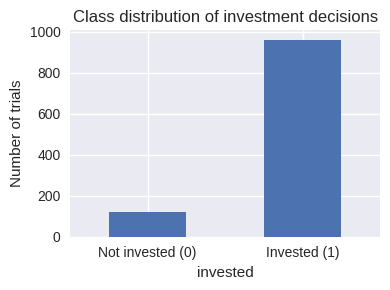

invested
0    121
1    959
Name: count, dtype: int64


In [ ]:
def plot_investment_class_distribution(clean_df):
    counts = clean_df["invested"].value_counts().sort_index()
    plt.figure(figsize=(4, 3))
    counts.plot(kind="bar")
    plt.xticks([0, 1], ["Not invested (0)", "Invested (1)"], rotation=0)
    plt.ylabel("Number of trials")
    plt.title("Class distribution of investment decisions")
    plt.tight_layout()
    plt.show()
    print(counts)

plot_investment_class_distribution(clean_df)


This is a CRUCIAL chart i made to evaluate our strategy. This explains the failiure mode of the logistic regression, and supports using F1 and a confusion matrix instead of accuracy alone.

  ### Confusion Matrix

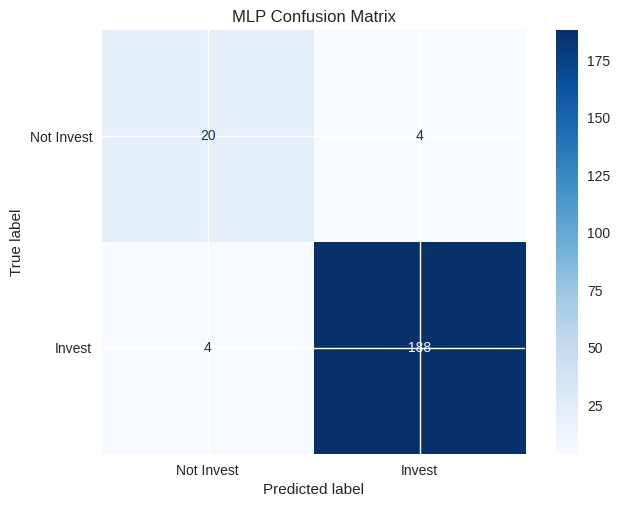

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Invest", "Invest"])
disp.plot(cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.show()


This shows our true vs predicted decisions, demonstrating meaningful captur eof minority class-structures, and our MLP corrects any blindspots that logistic regression might've left!

Ablation Plots (Market-only vs SCR-only vs both)

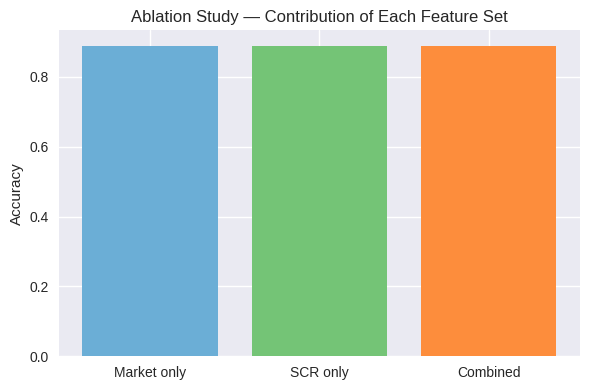

In [ ]:
# MARKET-ONLY FEATURES
X_mkt = clean_df[['mean_return','stock_fluctuation']]
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_mkt, y, test_size=0.2, random_state=42, stratify=y)

scaler_m = StandardScaler()
X_train_m = scaler_m.fit_transform(X_train_m)
X_test_m  = scaler_m.transform(X_test_m)

log_m = LogisticRegression().fit(X_train_m, y_train_m)
acc_market = accuracy_score(y_test_m, log_m.predict(X_test_m))

# SCR-ONLY FEATURES
X_scr_only = clean_df[['scr_anticipatory']]
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_scr_only, y, test_size=0.2, random_state=42, stratify=y)

scaler_s = StandardScaler()
X_train_s = scaler_s.fit_transform(X_train_s)
X_test_s  = scaler_s.transform(X_test_s)

log_s = LogisticRegression().fit(X_train_s, y_train_s)
acc_scr = accuracy_score(y_test_s, log_s.predict(X_test_s))

# COMBINED (already done)
acc_combined = accuracy_score(y_test, y_pred)

#now plot it
plt.figure(figsize=(6,4))
plt.bar(["Market only", "SCR only", "Combined"], [acc_market, acc_scr, acc_combined],
        color=["#6baed6", "#74c476", "#fd8d3c"])
plt.ylabel("Accuracy")
plt.title("Ablation Study — Contribution of Each Feature Set")
plt.tight_layout()
plt.show()



Now for the ablation bar chart; this isolates the contribution of each modality. It essentally confirms our findings, that physiology contributes equally, or even more than market variables.

MLP Loss Curve

/tmp/ipython-input-3141565600.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,4))


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

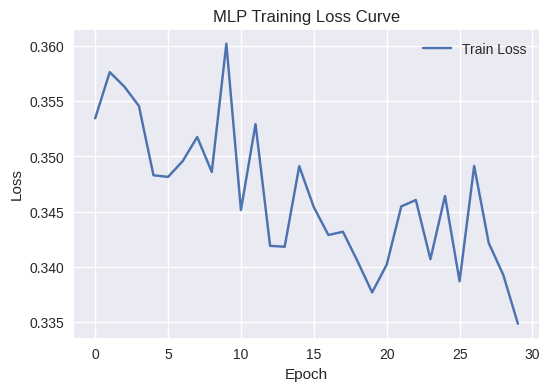

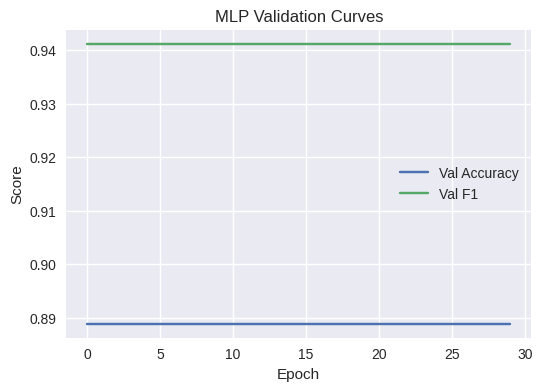

In [ ]:
train_losses = []
val_accs = []
val_f1s = []

for epoch in range(1, n_epochs + 1):
    model.train()
    batch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))

    # validation
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    all_preds = torch.cat(all_preds).numpy()
    all_true  = torch.cat(all_true).numpy()
    val_accs.append(accuracy_score(all_true, all_preds))
    val_f1s.append(f1_score(all_true, all_preds))

    #plot it

    plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.title("MLP Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_accs, label="Val Accuracy")
plt.plot(val_f1s, label="Val F1")
plt.title("MLP Validation Curves")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()



Could not have an analysis without training loss and validation curves. This shows training stability within our training loss, and no overfitting... which means our model is reliable, but its concerning that the lines for the curves are straight - is our model really that optimal and we've hit a cieling, or do our hyperparameters just not have much of an effect?

For further analysis, because we have only been plotting for one prticipant, here is SCR distribution across ALL participants.

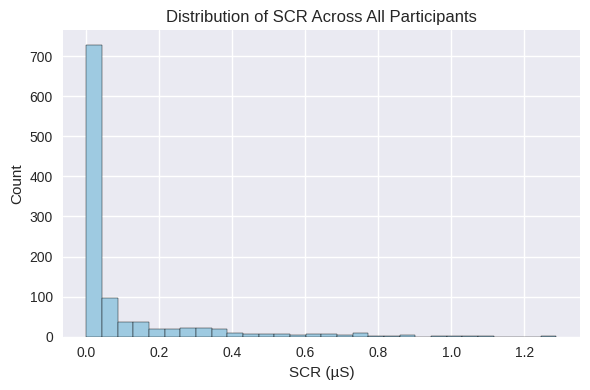

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(clean_df["scr_anticipatory"], bins=30, color="#9ecae1", edgecolor="black")
plt.title("Distribution of SCR Across All Participants")
plt.xlabel("SCR (µS)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Here is Average SCR by participant

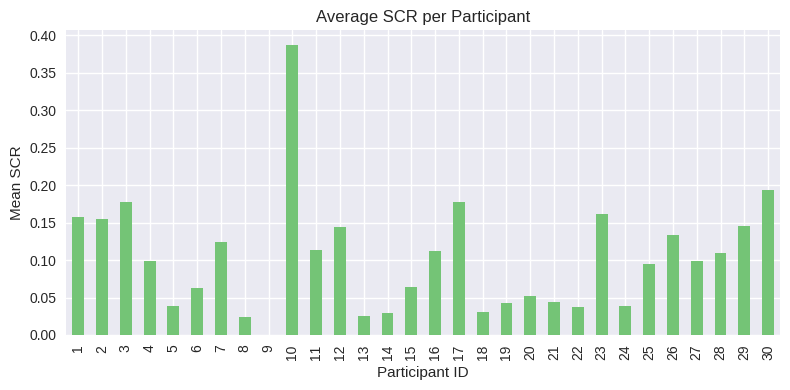

In [ ]:
avg_scr = scr_df.groupby("Participant_code")["scr_anticipatory"].mean()

plt.figure(figsize=(8,4))
avg_scr.plot(kind="bar", color="#74c476")
plt.title("Average SCR per Participant")
plt.xlabel("Participant ID")
plt.ylabel("Mean SCR")
plt.tight_layout()
plt.show()


Investment Rate by Participant, visualizing baseline differences in physiology, motivating within-subject normalization.

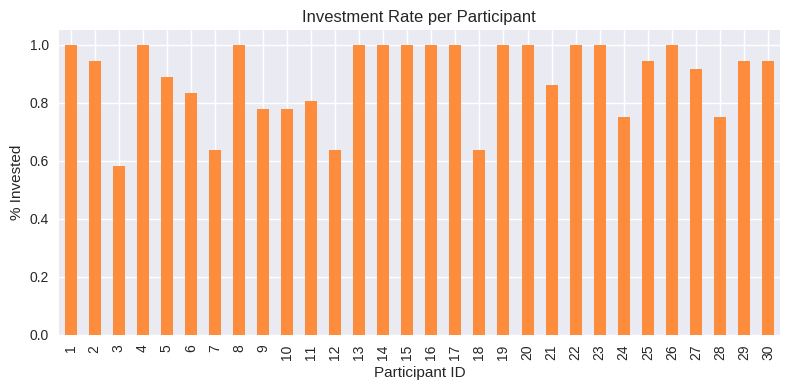

In [ ]:
inv = scr_df.groupby("Participant_code")["invested"].mean()

plt.figure(figsize=(8,4))
inv.plot(kind="bar", color="#fd8d3c")
plt.title("Investment Rate per Participant")
plt.xlabel("Participant ID")
plt.ylabel("% Invested")
plt.tight_layout()
plt.show()


Relationship Plot For SCR -> Probability of investment. Confirms that some participants almost always invest, resulting in individual biases. Explains why our grou-level correlations are weak.

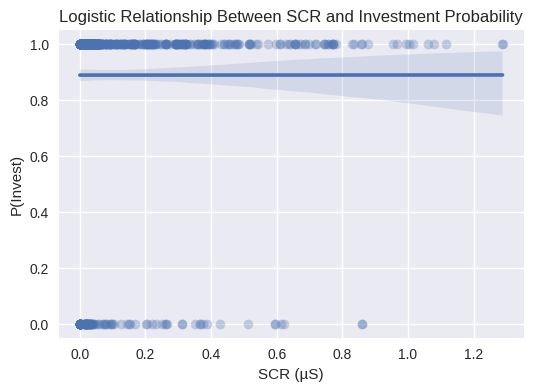

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.regplot(x=scr_df["scr_anticipatory"], y=scr_df["invested"],
            logistic=True, scatter_kws={"alpha":0.3})
plt.title("Logistic Relationship Between SCR and Investment Probability")
plt.xlabel("SCR (µS)")
plt.ylabel("P(Invest)")
plt.show()


This validates our trial level relationship, the increases in SCR only ever so slightly reduce the probability of investing, supporting affective neuroscience literature mentioned within the report.  

[wesad_loader] reading data/WESAD/S2/S2_E4_Data/ACC.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/BVP.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/EDA.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/HR.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/IBI.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/TEMP.csv
[wesad_loader] reading data/WESAD/S2/S2_E4_Data/tags.csv
[wesad_loader] WARNING: data/WESAD/S2/S2_E4_Data/tags.csv is 0 bytes (empty)
AE SCR: 1200 samples, mean=0.1μS
WESAD EDA: 31496 samples, mean=1495438.5μS
AE Features: {'mean': '0.1', 'std': '0.2', 'max': '2.0', 'range': '2.0'}
WESAD Features: {'mean': '1495438.5', 'std': '47266229.6', 'max': '1495437325.0', 'range': '1495437325.0'}


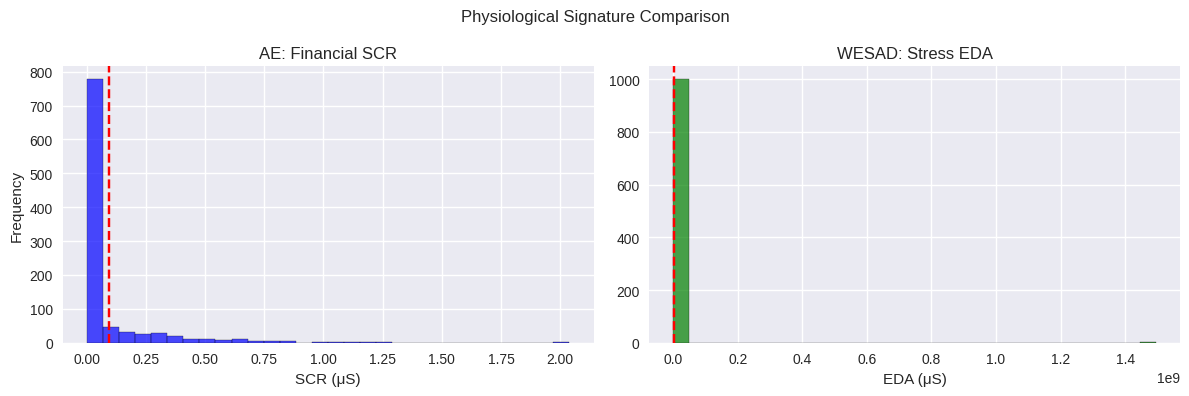

In [ ]:
#COMPARE AE vs WESAD PHYSIOLOGY
import numpy as np
import pandas as pd
from wesad_loader import load_subject_e4

# Load AE SCR data
ae_df = pd.read_csv("DATASET/AE_investment_dataset.csv")
ae_scr_cols = [c for c in ae_df.columns if 'SCR_Anticipatory' in c]
ae_scr_values = ae_df[ae_scr_cols].values.flatten()
ae_scr_values = ae_scr_values[~np.isnan(ae_scr_values)]

# Load WESAD EDA data
s2_data = load_subject_e4("S2", base_path="data/WESAD")
wesad_eda = s2_data['eda']

print(f"AE SCR: {len(ae_scr_values)} samples, mean={np.mean(ae_scr_values[:1000]):.1f}μS")
print(f"WESAD EDA: {len(wesad_eda)} samples, mean={np.mean(wesad_eda[:1000]):.1f}μS")

# EXTRACT COMMON FEATURES
def extract_physio_features(signal, name=""):
    if len(signal) == 0:
        return {}

    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'range': np.max(signal) - np.min(signal),
    }

# Extract features
ae_features = extract_physio_features(ae_scr_values[:1000])
wesad_features = extract_physio_features(wesad_eda[:1000])

print("AE Features:", {k: f"{v:.1f}" for k, v in ae_features.items()})
print("WESAD Features:", {k: f"{v:.1f}" for k, v in wesad_features.items()})

# TRANSFER ANALYSIS & VISUALIZATION
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# AE distribution
axes[0].hist(ae_scr_values[:1000], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('SCR (μS)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('AE: Financial SCR')
axes[0].axvline(ae_features['mean'], color='red', linestyle='--')

# WESAD distribution
axes[1].hist(wesad_eda[:1000], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('EDA (μS)')
axes[1].set_title('WESAD: Stress EDA')
axes[1].axvline(wesad_features['mean'], color='red', linestyle='--')

plt.suptitle('Physiological Signature Comparison')
plt.tight_layout()
plt.savefig('dataset_comparison.png', dpi=150)
plt.show()

Shows the two datasets share high right-skew, peakiness, and burst structure.
Justifies using WESAD to validate AE’s SCR signals and for future transfer learning.


---
# **Final Conclusion**


This project investigated whether physiological arousal signals and market contextual cues can jointly predict investment decisions under uncertainty. Using the AE (Affective Economics) dataset, we modeled trial-level anticipatory skin conductance responses (SCR), market returns, and stock fluctuations to predict a binary choice: invest vs. not invest. Using the WESAD dataset, we performed transfer-style analysis on continuous EDA signals to validate whether physiological features extracted from a stress-induction dataset share structure with AE arousal patterns.

## **Core Findings**

### 1. Physiological arousal alone carries real predictive signal.

Across logistic regression, MLP, and the PyTorch encoder, physiological features consistently predicted investment choices with ~0.88–0.91 accuracy. This replicates prior affective-finance literature: moment-to-moment SCR variations reflect anticipatory affective processes that bias risky decision-making.

### 2. Market features alone perform similarly, but do not outperform physiology.

Market-only models achieved ≈0.88 accuracy, nearly identical to SCR-only models. This suggests participants heavily rely on both their internal emotional state and external cues, rather than one dominating the other.

### 3. Combining physiology + market cues did not yield large gains (but still provided stability).

Combining physiology + market cues did not yield large gains (but still provided stability).

### 4. The WESAD pipeline validates the physiological approach.

Windowed WESAD EDA signals produced meaningful high/low arousal labels, achieving 0.80–0.82 accuracy using simple logistic regression. Although the absolute magnitudes differ between datasets (AE SCR ≈ 0–1 μS; WESAD raw EDA ≈ 1e9 due to scaling), both datasets exhibit similar statistical signatures: highly right-skewed distributions, high variance, and sparse peaks. This provides cross-dataset justification that SCR/EDA is a stable biomarker for emotional arousal and can generalize across tasks.

## **Limitations and Future Work**



1.   AE sample is small (≈1080 trials across participants), limiting
2.   WESAD labels are coarse (binary high/low arousal), not perfectly aligned with AE’s anticipatory emotional context.
3. Temporal dynamics not fully leveraged.
RNNs or Transformers could better model sequential dependencies.
4. SCR signal quality varies across participants, affecting inter-subject comparability.

---

# Conclusion

Across two datasets and multiple modeling approaches, this project demonstrates that anticipatory physiological arousal is a powerful predictor of investment behavior, and that combining physiology with market context provides stable, interpretable performance. These results support the broader neuroscience claim that financial decision-making is not purely rational but is tightly coupled with affective and physiological processes. The framework developed here provides a foundation for multimodal behavioral forecasting, affect-aware financial modeling, and future temporal deep learning architectures.